# Getting seed encoder model from linear unmixing data of step 4

In [2]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde


import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

plt.rcParams['text.usetex'] = True

# Create model to regress abundances for individual spectra

### Define encoder which converts spectrum to abundances

In [4]:
class LinearMixingEncoder(nn.Module):
    def __init__(self, M, K, hidden_size):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.BatchNorm1d(),
            nn.Linear(M, hidden_size),
            nn.BatchNorm1d(),
            nn.ReLU(),
            
            # Collection of hidden layers
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(),
            nn.ReLU(),
            
            # Convert to vector of mass abundances.
            nn.Linear(hidden_size, K), 
            
            # No subsequent BatchNorm on last layer.
            
            # Use leaky ReLU: has gradient !=0 at large negative values
            # so that very small abundances (large neg. values at this layer)
            # sit in a region of nonvanishing gradient
            nn.LeakyReLU()            
        )
        
        # Softmax to ensure abundances add up to 1
        self.smax = nn.SoftMax() 
        
    def forward(self, y):
        y_mlp = self.mlp(y);
        ms = self.smax(y_mlp);
        return ms

### Run through picklefiles, collect abundances regressed and corresponding spectra

In [ ]:
# Set analysis parameters
KEndmembers = 90
MSpectra = 2151

In [ ]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA)).T

In [ ]:
import pickle
import os

# Get number of spectra to analyze
dir_path = r'./results/step4/*.pkl'
resultsDirContents = [entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]
NSpectra = len(resultsDirContents)

# Create spectra lists
Is = np.zeros([NSpectra,MSpectra])

# Create model parameter lists
Fs = np.zeros([KEndmembers,MSpectra])
rhorads = np.zeros(KEndmembers)

# Create abundance list
Ms = np.zeros([NSpectra,KEndmembers])

# Create msoc list
trueMSOC = np.zeros(NSpectra)

# Populate F
with open(resultsDirContents[0], 'rb') as file:
        (model,_,F,_,_,_,_) = pickle.load(file)
        Fs = F
        rhorads[:-1] = np.array(model.rhorad.tolist())
        rhorads[-1] = model.rrsoc.detach().item()
        
# Populate lists
for iSpec in tqdm(range(len(resultsDirContents))) :
    with open(resultsDirContents[iSpec], 'rb') as file:
        (model,_,_,_,_,_,msoc) = pickle.load(file)
        
        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T
        
        Ms[iSpec,:-1]   = tcorrms
        Ms[iSpec,-1]    = msoc
        trueMSOC[iSpec] = msoc
        
        Is[iSpec,:] = np.dot(A(Ms[iSpec,:],rhorads[iSpec,:]),F)
        


### Train seed encoder model

In [ ]:
# Truth-level outputs: regressed abundances from an LMM
tMs  = torch.tensor(Ms.tolist())

# Truth-level inputs: Individual spectra
tIs = torch.tensor(Is.tolist())

# Training settings, optimizer declarations
nepochs = 20000
model = LinearMixingEncoder(MSpectra, KEndmembers, 512)
optimizer = optim.Adam(model.parameters(), lr = 0.000005, betas=(0.99,0.999))
preds = []

In [ ]:
# Optimizer tracking
cEpoch = 0
lossTracking = np.zeros(nepochs);

In [107]:
for epoch in tqdm(range(nepochs)) :
    preds = model(tIs)
    loss = (preds - tMs)**2
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossTracking[cEpoch] = loss.detach().item()
    cEpoch += 1

print("Epoch ",epoch,": ", lossTracking[-1], lossTracking[-1] / (0.01 ** 2) / (KEndmembers))

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch  19999 :  0.0007158684893511236 0.0006009259377606213 0.0027937049640196247


### Check training output

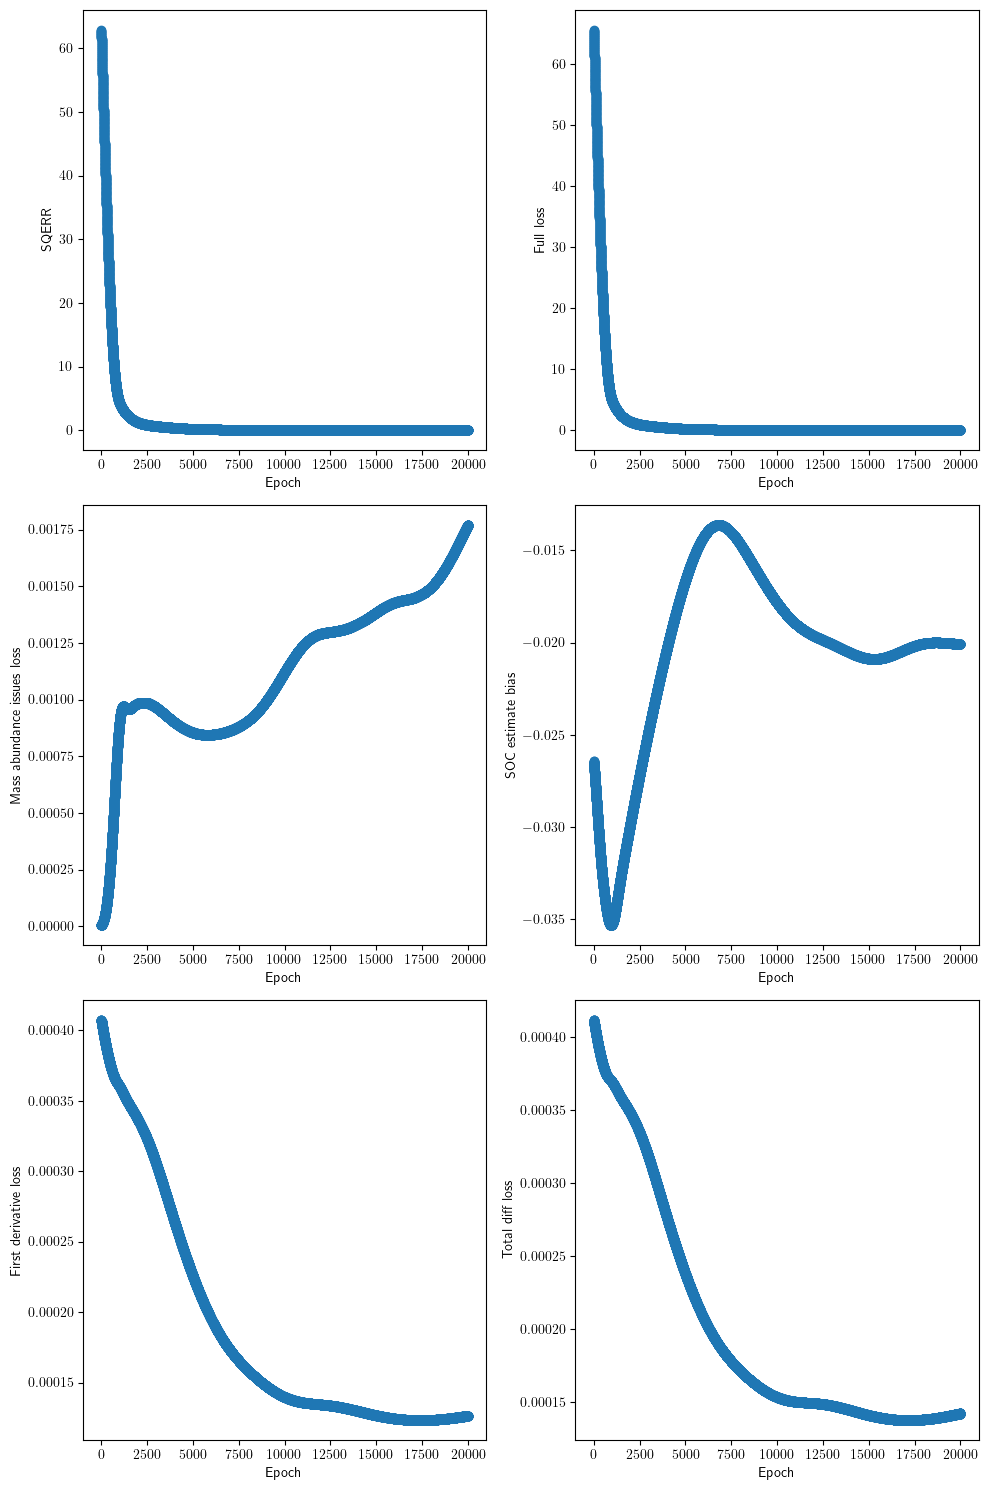

In [109]:
_, axarr = plt.subplots(1,1,figsize=(10,15))

axarr[0,0].scatter([i for i in range(len(model.lsq))],preds[:,-1])
axarr[0,0].set_xlabel("Predicted SOC abundance")
axarr[0,0].set_ylabel("True SOC abundance")

axarr[0,1].scatter([i for i in range(len(model.loss))],model.loss)
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("#chi^2/NDF")

plt.tight_layout()
plt.show()